In [23]:
import os
import pandas as pd
from pathlib import Path
import importlib
import functions
importlib.reload(functions)
from functions import *
from functions_plots import *
from itertools import product

from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

In [24]:
# Load data
data_folder_path = Path('data/')
data = pd.read_csv(data_folder_path / 'data_train_all.csv')
data_columns = pd.read_csv(data_folder_path / 'data_train_all_columns.csv')

print("Training data length:", len(data))

predictor_columns = data_columns[data_columns['column_type'].isin(['predictor_n_grams', 'predictor_continuous'])]['column_name'].tolist()
print(f"Number of predictor columns: {len(predictor_columns)}")

target_columns = data_columns[data_columns['column_type'] == 'target']['column_name'].tolist()
print(f"Target columns: {target_columns}")

# Merge back with the raw data so that we can use the extra column to filter later
data_raw = pd.read_csv(data_folder_path / 'chordonomicon_raw.csv', low_memory=False)

print(data_raw.columns)
print(data.columns)

keys = ['spotify_song_id', 'decade', 'main_genre']
data = data.merge(data_raw, on=keys, how='left', suffixes=('', '_raw'))

Training data length: 255606
Number of predictor columns: 119
Target columns: ['spotify_popularity', 'on_hot100', 'decade', 'main_genre']
Index(['id', 'chords', 'release_date', 'genres', 'decade', 'rock_genre',
       'artist_id', 'main_genre', 'spotify_song_id', 'spotify_artist_id'],
      dtype='object')
Index(['chords_x', 'simplified_chords_x', 'spotify_song_id', 'chords_y',
       'missing_notes', 'simplified_chords_y', 'drone_ratio',
       'average_overlap', 'average_2overlap', 'average_3overlap',
       ...
       'contains_G,C,Amin,F,G', 'contains_F,G,C,Amin,F',
       'contains_Amin,C,G,Amin,C', 'contains_D,G,C,G,C', 'contains_C,G,C,G,D',
       'contains_G,Emin,C,G,Emin', 'contains_C,Amin,C,Amin,C',
       'contains_F,Amin,G,F,Amin', 'track_id', 'on_hot100'],
      dtype='object', length=144)


In [25]:
# Select target variable and type

target_variable = 'on_hot100'
target_type = 'binary'

# Drop NaN values in target variable from entire dataset
if data[target_variable].isna().any():
    data = data[data[target_variable].notna()].reset_index(drop=True)
    print(f"Rows after dropping NaN in {target_variable}: {len(data)}")

Rows after dropping NaN in on_hot100: 181159


['lasso_feature_importance_decade.csv', 'lasso_feature_importance_on_hot100.csv', 'lasso_feature_importance_main_genre.csv', 'lasso_feature_importance_spotify_popularity.csv']
Index(['feature', 'importance'], dtype='object')
['drone_ratio', 'average_overlap', 'average_2overlap', 'unique_5gram_density', 'maj_triad_ratio', 'contains_C,D,G', 'contains_Emin,C,G']


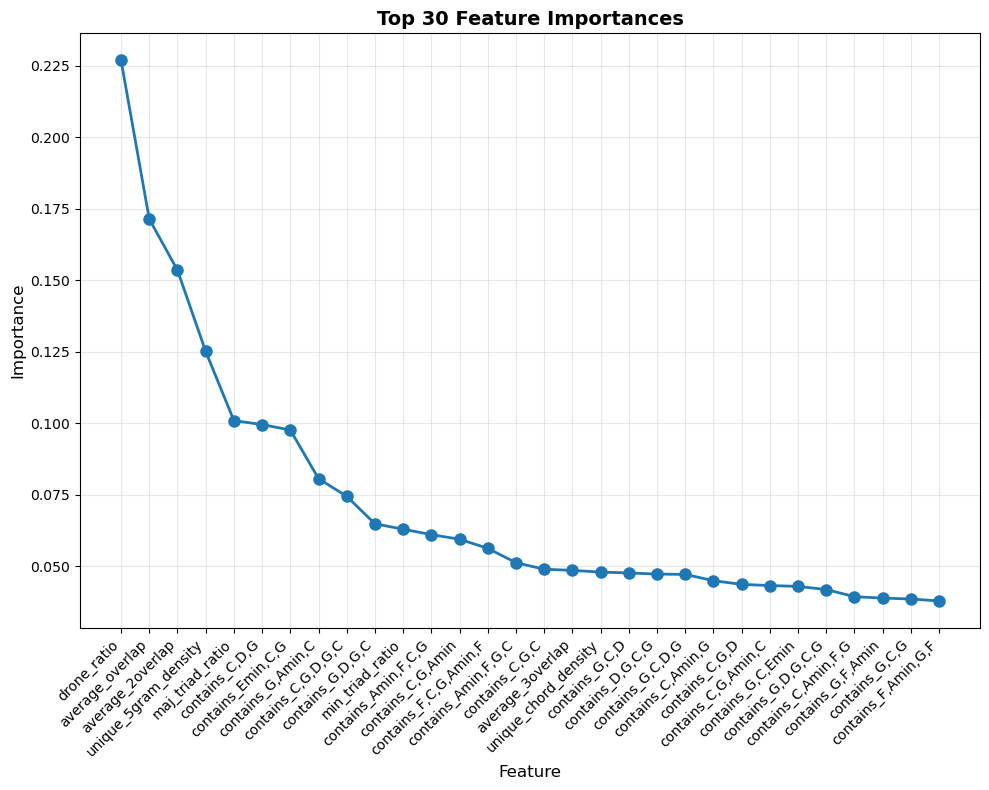

In [34]:
# select features here
path_feature_selection = Path('feature_selection/')
print(os.listdir(path_feature_selection))

feature_selection = pd.read_csv(path_feature_selection / f'lasso_feature_importance_{target_variable}.csv')
print(feature_selection.columns)

# # Plot feature importance for all features
#ax = plot_feature_importance(feature_selection)

# Plot feature importance for top N features
ax = plot_feature_importance_df(feature_selection, top_n=30)

# Select top N features or comment out to use all features
predictor_columns = feature_selection.head(7)['feature'].astype(str).tolist()
print(predictor_columns)

In [35]:
# Filter data here

data_filtered = data[pd.to_numeric(data['decade'], errors='coerce') >= 1990].reset_index(drop=True)

unique_decades = pd.to_numeric(data_filtered['decade'], errors='coerce').dropna().astype(int).unique()
unique_decades = sorted(unique_decades)
print("Unique decades after filter:", unique_decades)

# Make a dataframe with predictor features
data_X = data_filtered[predictor_columns]

Unique decades after filter: [np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2020)]


In [36]:
# 5-fold cross validation (stratified for classification to keep class ratios per fold)
if target_variable == 'spotify_popularity':
    # Use regular KFold for regression
    cv = KFold(n_splits=5, shuffle=True, random_state=145)
else:
    # Use StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=145)

# When modeling genre, we need to encode the labels (all other target variables are numeric already)
if target_variable == 'main_genre':
    le = LabelEncoder()
    data_y = le.fit_transform(data_filtered[target_variable])
else:
    data_y = data_filtered[target_variable]

#When modeling hot 100, we need to resample the data due to the class imbalance 
if target_variable == 'on_hot100':
    ros = RandomOverSampler(random_state=0)
    data_X, data_y = ros.fit_resample(data_X,data_y)
   

In [37]:
results_dummy = evaluate_dummy_baseline(data_X, data_y, cv=cv, target_type=target_type, random_state=0)


Evaluating Dummy Baseline...
Cross-validation folds: 5


/Users/elizabethrizor/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/elizabethrizor/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Dummy Baseline - Binary Target
Parameters: strategy=most_frequent

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.5000 (+/- 0.0000)
Precision                     :  0.2000 (+/- 0.2449)




/Users/elizabethrizor/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [38]:
# Train and fit logistic regression model here (uses ridge regression for regression variables)
results_lr = train_logistic_regression(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)


Training Logistic Regression/Ridge...
Cross-validation folds: 5

Logistic Regression - Binary Target
Parameters: C=1.0, penalty=l2, solver=lbfgs

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.5484 (+/- 0.0015)
F1                            :  0.5484 (+/- 0.0016)
Precision                     :  0.5484 (+/- 0.0016)
Recall                        :  0.5483 (+/- 0.0020)
Roc Auc                       :  0.5718 (+/- 0.0016)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.5486 (+/- 0.0002)
F1                            :  0.5485 (+/- 0.0004)
Precision                     :  0.5486 (+/- 0.0003)
Recall                        :  0.5484 (+/- 0.0010)
Roc Auc                       :  0.5719 (+/- 0.0004)





📐 Training Lasso...
Cross-validation folds: 5


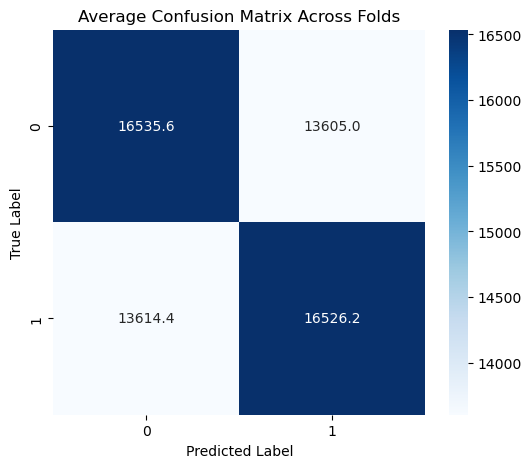


Lasso - Binary Target
Parameters: alpha=0.1, max_iter=5000

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.5485 (+/- 0.0014)
F1                            :  0.5484 (+/- 0.0015)
Precision                     :  0.5485 (+/- 0.0015)
Recall                        :  0.5483 (+/- 0.0019)
Roc Auc                       :  0.5718 (+/- 0.0016)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.5486 (+/- 0.0004)
F1                            :  0.5485 (+/- 0.0003)
Precision                     :  0.5486 (+/- 0.0005)
Recall                        :  0.5484 (+/- 0.0007)
Roc Auc                       :  0.5719 (+/- 0.0004)




In [39]:
# Train and fit Lasso model here
results_lasso = train_lasso(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    alpha=0.1,
    max_iter=5000,
    random_state=42,
    plot_confusion_matrix=True 
)



Training Random Forest...
Cross-validation folds: 5


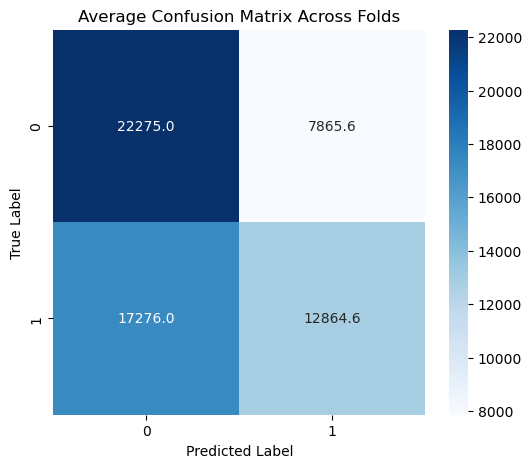

python(35154) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35161) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Random Forest - Binary Target
Parameters: n_estimators=100, max_depth=4, min_samples_leaf=1

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.5829 (+/- 0.0031)
F1                            :  0.5057 (+/- 0.0073)
Precision                     :  0.6206 (+/- 0.0049)
Recall                        :  0.4268 (+/- 0.0105)
Roc Auc                       :  0.6162 (+/- 0.0028)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.5838 (+/- 0.0009)
F1                            :  0.5067 (+/- 0.0048)
Precision                     :  0.6219 (+/- 0.0029)
Recall                        :  0.4276 (+/- 0.0080)
Roc Auc                       :  0.6176 (+/- 0.0013)




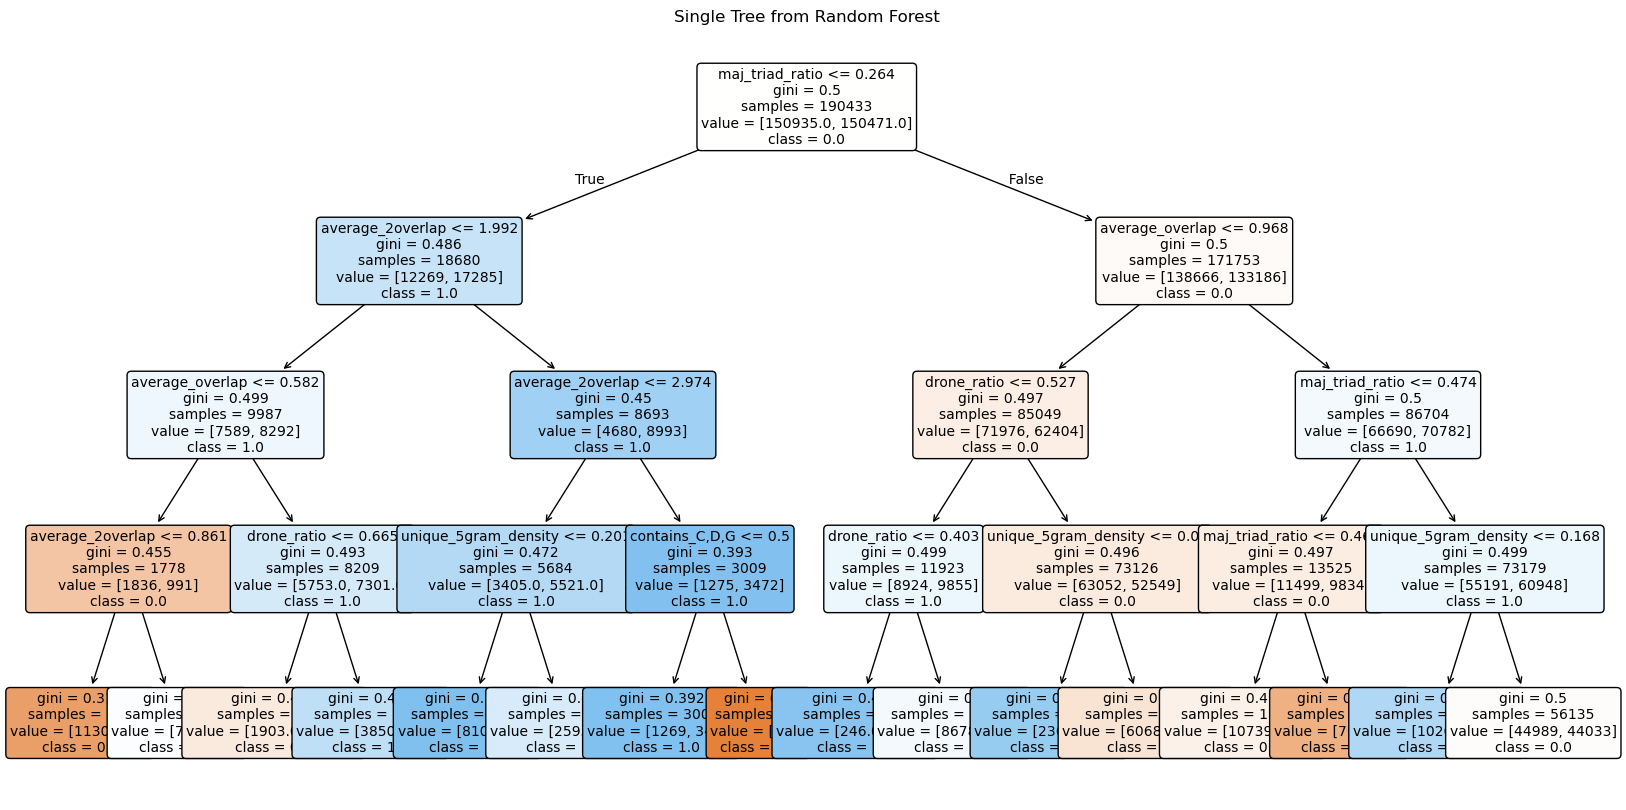

In [50]:
results_rf = train_random_forest(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    n_estimators=100,
    max_depth=4,
    random_state=42,
    plot_confusion_matrix=True,
    plot_tree_flag=True
)


In [ ]:
# Train and fit Random Forests model here

from itertools import product
import pandas as pd

# Define parameter options
n_estimators_options = [1, 2, 4, 16, 64, 100, 200]
max_depth_options = [3, 5, 7, 10, None]
min_samples_split_options = [2, 5, 10]
min_samples_leaf_options = [1, 2, 4]

# Create full parameter grid
param_grid = list(product(
    n_estimators_options,
    max_depth_options,
    min_samples_split_options,
    min_samples_leaf_options
))

results_list = []

for n_estimators, max_depth, min_samples_split, min_samples_leaf in param_grid:
    print(f"\nTraining Random Forest with n_estimators={n_estimators}, "
          f"max_depth={max_depth}, min_samples_split={min_samples_split}, "
          f"min_samples_leaf={min_samples_leaf}")
    
    # Run your existing function
    scores_rf = train_random_forest(
        data_X,
        data_y,
        cv=cv,
        target_type=target_type,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        plot_confusion_matrix=False  # skip plotting for grid search
    )
    
    # Collect mean metrics across folds
    mean_metrics = {metric: scores_rf[metric].mean() for metric in scores_rf if metric.startswith("test_")}
    mean_metrics.update({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    })
    
    results_list.append(mean_metrics)

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results_list)

# Sort by best accuracy or any metric you care about
results_df = results_df.sort_values(by='test_accuracy', ascending=False)




Training Random Forest with n_estimators=1, max_depth=3, min_samples_split=2, min_samples_leaf=1

Training Random Forest...
Cross-validation folds: 5

Random Forest - Binary Target
Parameters: n_estimators=1, max_depth=3, min_samples_leaf=1

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.5429 (+/- 0.0146)
F1                            :  0.3948 (+/- 0.0847)
Precision                     :  0.5879 (+/- 0.0306)
Recall                        :  0.3102 (+/- 0.0940)
Roc Auc                       :  0.5501 (+/- 0.0137)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.5436 (+/- 0.0129)
F1                            :  0.3959 (+/- 0.0847)
Precision                     :  0.5893 (+/- 0.0284)
Recall                        :  0.3111 (+/- 0.0940)
Roc Auc                       :  0.5510 (+/- 0.0121)



Training Random Forest with n_estima

,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,n_estimators,max_depth,min_samples_split,min_samples_leaf
222,0.996971,0.993978,1.0,0.996980,0.999534,64,NaN,10,1
267,0.996968,0.993972,1.0,0.996977,0.999534,100,NaN,10,1
261,0.996961,0.993959,1.0,0.996970,0.999534,100,NaN,2,1
264,0.996961,0.993959,1.0,0.996970,0.999534,100,NaN,5,1
216,0.996951,0.993939,1.0,0.996960,0.999534,64,NaN,2,1


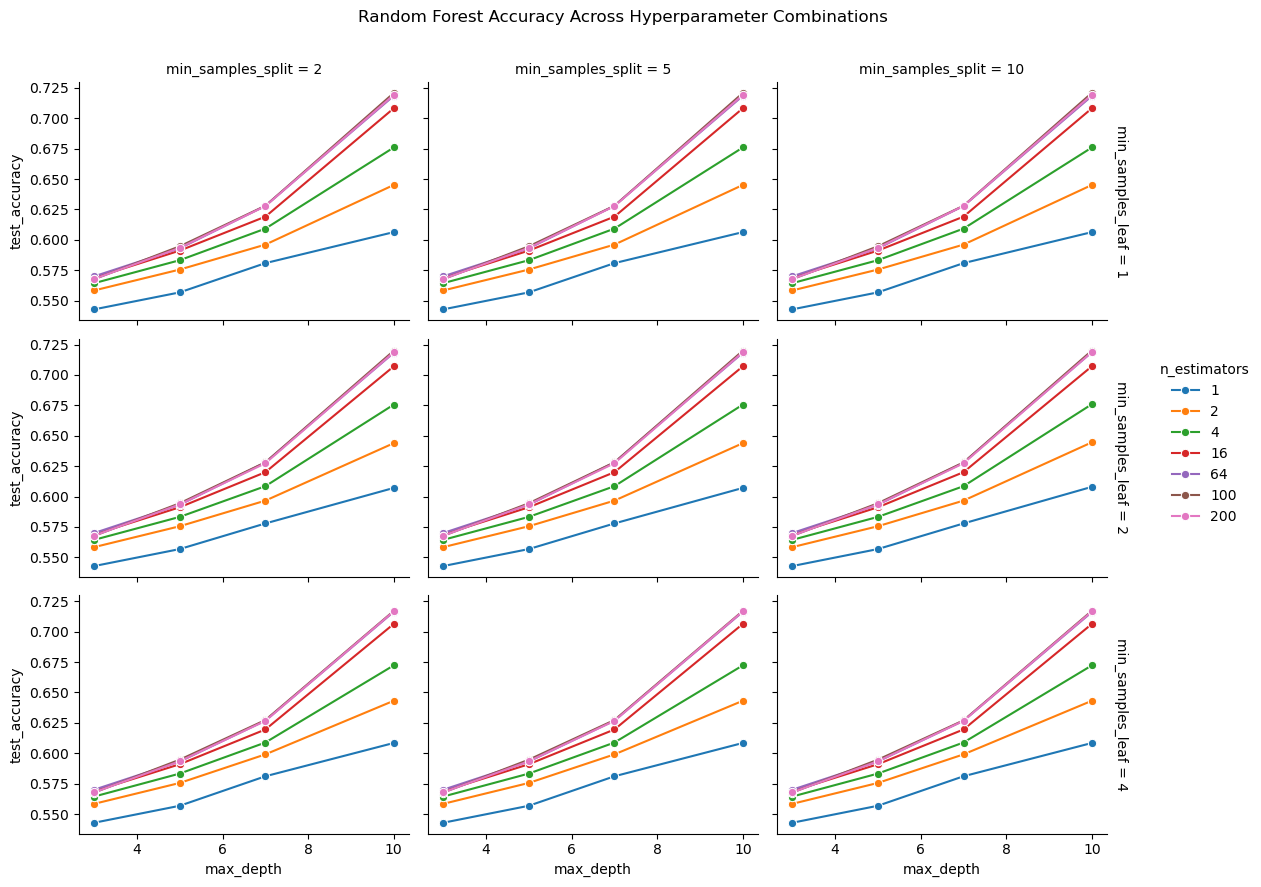

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort for clarity
results_df = results_df.sort_values(by='test_accuracy', ascending=False)

# Facet grid: one subplot per combination of min_samples_split and min_samples_leaf
g = sns.FacetGrid(
    results_df,
    col='min_samples_split',
    row='min_samples_leaf',
    hue='n_estimators',
    margin_titles=True,
    height=3,
    aspect=1.3
)

g.map(sns.lineplot, 'max_depth', 'test_accuracy', marker='o')
g.add_legend()

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Random Forest Accuracy Across Hyperparameter Combinations")
plt.show()

In [ ]:
#final best model is depth = 10, min samples leaf = 1, estimators = 100, min samples split = 10, training on 7 features (no multicollinearity) and predicting from 1990s to 2020s 


Test data length: 45107
Number of predictor columns: 119
Target columns: ['spotify_popularity', 'on_hot100', 'decade', 'main_genre']
Index(['id', 'chords', 'release_date', 'genres', 'decade', 'rock_genre',
       'artist_id', 'main_genre', 'spotify_song_id', 'spotify_artist_id'],
      dtype='object')
Index(['chords_x', 'simplified_chords_x', 'spotify_song_id', 'chords_y',
       'missing_notes', 'simplified_chords_y', 'drone_ratio',
       'average_overlap', 'average_2overlap', 'average_3overlap',
       ...
       'contains_G,C,Amin,F,G', 'contains_F,G,C,Amin,F',
       'contains_Amin,C,G,Amin,C', 'contains_D,G,C,G,C', 'contains_C,G,C,G,D',
       'contains_G,Emin,C,G,Emin', 'contains_C,Amin,C,Amin,C',
       'contains_F,Amin,G,F,Amin', 'track_id', 'on_hot100'],
      dtype='object', length=144)
